Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2017/2018  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 4: Ansambli i procjena parametara

*Verzija: 0.1  
Zadnji put ažurirano: 11. prosinca 2017.*

(c) 2015-2017 Jan Šnajder, Domagoj Alagić  

Objavljeno: **11. prosinca 2017.**  
Rok za predaju: **18. prosinca 2017. u 07:00h**

------------------------------

Objavljeno: **6. prosinca 2016.**<br>
Rok za predaju: U terminu vježbe u tjednu od **12. prosinca 2016.**

### Upute

Četvrta laboratorijska vježba sastoji se od **četiri** zadatka. Kako bi kvalitetnije, ali i na manje zamoran način usvojili gradivo ovog kolegija, potrudili smo se uključiti tri vrste zadataka: **1)** implementacija manjih algoritama, modela ili postupaka; **2)** eksperimenti s raznim modelima te njihovim hiperparametrima, te **3)** primjena modela na (stvarnim) podatcima. Ovim zadatcima pokrivamo dvije paradigme učenja: učenje izgradnjom (engl. *learning by building*) i učenje eksperimentiranjem (engl. *learning by experimenting*).

U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import mlutils
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Ansambli (glasovanje)

#### (a)

Vaš je zadatak napisati razred `VotingClassifierDIY` koji implementira glasački ansambl. Konstruktor razreda ima **dva** parametra: `clfs` koji predstavlja listu klasifikatora (objekata iz paketa `sklearn`) i `voting_scheme` koji označava radi li se o glasovanju prebrojavanjem (`SCHEME_COUNTING`) ili usrednjavanjem (`SCHEME_AVERAGING`). Glasovanje prebrojavanjem jednostavno vraća najčešću oznaku klase, dok glasovanje usrednjavanjem uprosječuje pouzdanosti klasifikacije u neku klasu (po svim klasifikatorima) te vraća onu s najvećom pouzdanošću. Primijetite da svi klasifikatori imaju jednake težine. O komplementarnosti klasifikatora vodimo računa tako da koristimo jednake klasifikatore s različitim hiperparametrima.

Razred sadržava metode `fit(X, y)` za učenje ansambla i dvije metode za predikciju: `predict(X)` i `predict_proba(X)`. Prva vraća predviđene oznake klasa, a druga vjerojatnosti pripadanja svakoj od klasa za svaki od danih primjera iz `X`.

**NB:** Jedan od razreda koji bi Vam mogao biti koristan jest [`collections.Counter`](https://docs.python.org/2/library/collections.html#collections.Counter). Također vrijedi i za funkcije [`numpy.argmax`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) i [`numpy.dstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html).

In [2]:
from collections import Counter

class VotingClassifierDIY(object):
    
    SCHEME_COUNTING = "counting"
    SCHEME_AVERAGING = "averaging"
    
    def __init__(self, clfs, voting_scheme=SCHEME_COUNTING):
        self.clfs = clfs
        self.voting_scheme = voting_scheme
        
    def fit(self, X, y):
        for clf in self.clfs:
            clf.fit(X, y)
    
    def predict_proba(self, X):
        return np.mean([clf.predict_proba(X) for clf in self.clfs], axis=0)
                
    def predict(self, X):
        if self.voting_scheme == self.SCHEME_COUNTING:
            return np.asarray([Counter([clf.predict(x.reshape(1, -1)).item() for clf in self.clfs]).most_common(1)[0][0] for x in X])
        elif self.voting_scheme == self.SCHEME_AVERAGING:
            return self.clfs[0].classes_[np.argmax(self.predict_proba(X), axis=1)]

#### (b)

Uvjerite se da Vaša implementacija radi jednako onoj u razredu [`ensemble.VotingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html), i to pri oba načina glasovanja (parametar `voting`). Parametar `weights` ostavite na pretpostavljenoj vrijednosti. Za ovu provjeru koristite tri klasifikatora logističke regresije s različitom stopom regularizacije i brojem iteracija. Koristite skup podataka dan u nastavku. Ekvivalentnost implementacije najlakše je provjeriti usporedbom izlaza funkcije `predict` (kod prebrojavanja) i funkcije `predict_proba` (kod usrednjavanja).

**NB:** Ne koristimo SVM jer njegova ugrađena (probabilistička) implementacija nije posve deterministička, što bi onemogućilo robusnu provjeru Vaše implementacije.

In [3]:
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

X_voting, y_voting = make_classification(n_samples=1000, n_features=4, n_redundant=0, n_informative=3, n_classes=3, n_clusters_per_class=2)

In [4]:
clf1 = LogisticRegression(C=0.1, max_iter=10)
clf2 = LogisticRegression(C=1, max_iter=100)
clf3 = LogisticRegression(C=100, max_iter=1000)

In [5]:
eclf_hard_ots = VotingClassifier(estimators=[('lr1', clf1), ('lr2', clf2), ('lr3', clf3)], voting='hard')
eclf_hard_diy = VotingClassifierDIY([clf1, clf2, clf3], voting_scheme="counting")

eclf_hard_ots.fit(X_voting, y_voting)
eclf_hard_diy.fit(X_voting, y_voting)

print((eclf_hard_ots.predict(X_voting) == eclf_hard_diy.predict(X_voting)).all())

True


In [6]:
eclf_soft_ots = VotingClassifier(estimators=[('lr1', clf1), ('lr2', clf2), ('lr3', clf3)], voting='soft')
eclf_soft_diy = VotingClassifierDIY([clf1, clf2, clf3], voting_scheme="averaging")

eclf_soft_ots.fit(X_voting, y_voting)
eclf_soft_diy.fit(X_voting, y_voting)

print((eclf_soft_ots.predict_proba(X_voting) == eclf_soft_diy.predict_proba(X_voting)).all())
print((eclf_soft_ots.predict(X_voting) == eclf_soft_diy.predict(X_voting)).all())

True
True


**Q:** Kada je prebrojavanje bolje od usrednjavanja? Zašto? A obratno?  
**Q:** Bi li se ovakav algoritam mogao primijeniti na regresiju? Kako?

**A:** Prebrojavanje je bolje kod klasifikatora s izračunatim težinama, dok je usrednjavanje bolje kod izjednačenih/nepoznatih težina klasifikatora, jer daje prednost "samouvjerenijim" klasifikatorima.

**A:** Algoritam se može primijeniti na regresiju tako da ansambl umjesto klase $y$ za koju je zbroj glasova najveći, vraća uprosječeni umnožak $w_j h_j(x)$ po svim klasifikatorima.

### 2. Ansambli (*bagging*)

U ovom zadatku ćete isprobati tipičnog predstavnika *bagging*-algoritma, **algoritam slučajnih šuma**. Pitanje na koje želimo odgovoriti jest kako se ovakvi algoritmi nose s prenaučenošću, odnosno, smanjuje li *bagging* varijancu modela.

Eksperiment ćete provesti na danom skupu podataka:

In [7]:
from sklearn.model_selection import train_test_split

X_bag, y_bag = make_classification(n_samples=1000, n_features=20, n_redundant=1, n_informative=17, n_classes=3, n_clusters_per_class=2)
X_bag_train, X_bag_test, y_bag_train, y_bag_test = train_test_split(X_bag, y_bag, train_size=0.7, random_state=69)

Razred koji implementira stablo odluke jest [`tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Prvo naučite **stablo odluke** (engl. *decision tree*) na skupu za učenje, ali tako da je taj model presložen. To možete postići tako da povećate najveću moguću dubinu stabla (parametar `max_depth`). Ispišite pogrešku na skupu za ispitivanje (pogrešku 0-1; pogledajte paket [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss

clf = DecisionTreeClassifier()
clf.fit(X_bag_train, y_bag_train)

print(zero_one_loss(y_bag_test, clf.predict(X_bag_test)))

0.46


Sada isprobajte algoritam slučajnih šuma (dostupan u razredu [`ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) za različit broj stabala $L \in [1, 30]$. Iscrtajte pogrešku na skupu za učenje i na skupu za ispitivanje u ovisnosti o tom hiperparametru. Ispišite najmanju pogrešku na skupu za ispitivanje.

0.196666666667 23


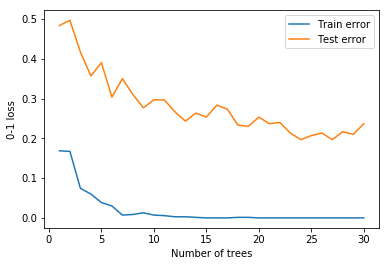

In [9]:
from sklearn.ensemble import RandomForestClassifier

numbers_of_trees = np.arange(1,31)
train_errors = []
test_errors = []

for number_of_trees in numbers_of_trees:
    clf = RandomForestClassifier(n_estimators=number_of_trees)
    clf.fit(X_bag_train, y_bag_train)
    
    train_errors.append(zero_one_loss(y_bag_train, clf.predict(X_bag_train)))
    test_errors.append(zero_one_loss(y_bag_test, clf.predict(X_bag_test)))
    
print(test_errors[np.argmin(test_errors)], np.argmin(test_errors))

plt.plot(numbers_of_trees, train_errors, label='Train error')
plt.plot(numbers_of_trees, test_errors, label='Test error')
plt.xlabel('Number of trees')
plt.ylabel('0-1 loss')
plt.legend(loc='best')
plt.show()

**Q:** Što možete zaključiti iz ovih grafikona?  
**Q:** Kako *bagging* postiže diverzifikaciju pojedinačnih osnovnih modela?  
**Q:** Koristi li ovaj algoritam složeni ili jednostavni osnovni model? Zašto?

**A:** Ukoliko je broj primjera/značajki velik a broj stabala malen, može se lako dogoditi da određeni primjeri/značajke budu propuštene u *bootstrap* uzorcima, što vodi slabijoj prediktivnoj moći slučajne šume.

**A:** *Bagging* svaki osnovni model trenira nad *bootstrap* uzorkom iz skupa za učenje, odnosno nad pojedinim setom iz multiseta kombinacija s ponavljanjem inicijalnog skupa za učenje. Navedeno uzorkovanje provodi se i nad značajkama (*attribute bagging*).

**A:** Algoritam *Random Forest* koristi jednostavne osnovne modele, jer im je treniranjem nad *bootstrap* uzorkom smanjena varijanca i ponešto povećana pristranost.

### 3. Ansambli (*boosting*)

U ovom zadatku pogledat ćemo klasifikacijski algoritam AdaBoost, koji je implementiran u razredu [`ensemble.AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). Ovaj algoritam tipičan je predstavnik *boosting*-algoritama.

Najprije ćemo generirati eksperimentalni skup podataka koristeći [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html). Ova funkcija stvara dvodimenzijski klasifikacijski problem u kojem su dva razreda podataka raspoređena u obliku kružnica, tako da je jedan razred unutar drugog.

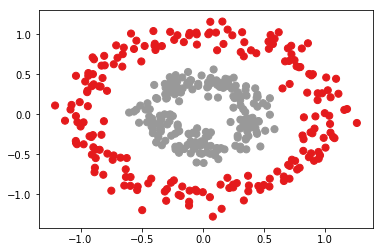

In [10]:
from sklearn.datasets import make_circles

circ_X, circ_y = make_circles(n_samples=400, noise=0.1, factor=0.4)
mlutils.plot_2d_clf_problem(circ_X, circ_y)

#### (a)

*Boosting*, kao vrsta ansambla, također se temelji na kombinaciji više klasifikatora s ciljem boljih prediktivnih sposobnosti. Međutim, ono što ovakav tip ansambla čini zanimljivim jest to da za osnovni klasifikator traži **slabi klasifikator** (engl. *weak classifier*), odnosno klasifikator koji radi tek malo bolje od nasumičnog pogađanja. Često korišteni klasifikator za tu svrhu jest **panj odluke** (engl. *decision stump*), koji radi predikciju na temelju samo jedne značajke ulaznih primjera. Panj odluke specijalizacija je **stabla odluke** (engl. *decision tree*) koje smo već spomenuli. Panj odluke stablo je dubine 1. Stabla odluke implementirana su u razredu [`tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Radi ilustracije, naučite ansambl (AdaBoost) koristeći panj odluke kao osnovni klasifikator, ali pritom isprobavajući različit broj klasifikatora u ansamblu iz skupa $L \in \{1, 2, 3, 50\}$. Prikažite decizijske granice na danom skupu podataka za svaku od vrijednosti korištenjem pomoćne funkcije `mlutils.plot_2d_clf_problem`.

**NB:** Još jedan dokaz da hrvatska terminologija zaista može biti smiješna. :)

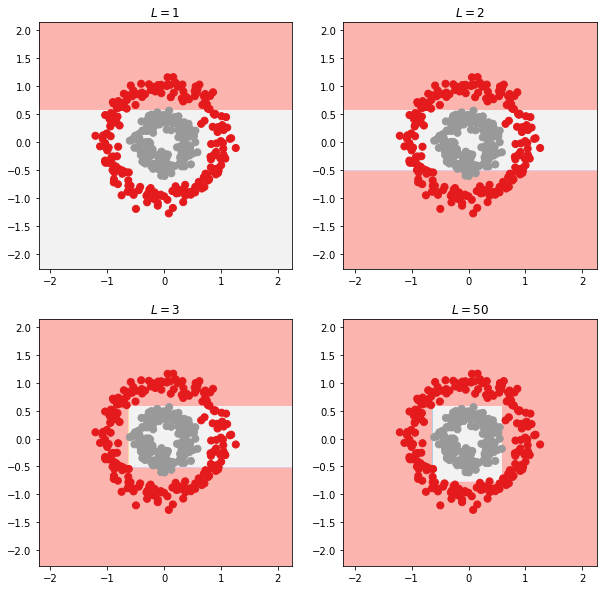

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

numbers_of_stumps = [1, 2, 3, 50]
plt.figure(figsize=(10,10))

for i, number_of_stumps in enumerate(numbers_of_stumps):
    eclf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=number_of_stumps)
    
    eclf.fit(circ_X, circ_y)
    
    plt.subplot(2, 2, i+1)
    plt.title("$L={0}$".format(number_of_stumps))
    mlutils.plot_2d_clf_problem(circ_X, circ_y, lambda x : eclf.predict(x))

plt.show()

**Q:** Kako AdaBoost radi? Ovise li izlazi pojedinih osnovnih modela o onima drugih?  
**Q:** Je li AdaBoost linearan klasifikator? Pojasnite.

**A:** AdaBoost u svakoj *boosting* iteraciji povećava težine krivo klasificiranim primjerima iz prethodne iteracije, što znači da je svaki sljedeći osnovni model prisiljen koncentrirati se na primjere s čijom su klasifikacijom njegovi prethodnici imali problema.

**A:** AdaBoost je linearna kombinacija osnovnih klasifikatora, no ukoliko osnovni klasifikatori nisu linearni ni AdaBoost neće biti linearan, jer ne predstavlja linearnu funkciju ulaznih podataka.

#### (b)

Kao što je i za očekivati, broj klasifikatora $L$ u ansamblu predstavlja hiperparametar algoritma *AdaBoost*. U ovom zadatku proučit ćete kako on utječe na generalizacijsku sposobnost Vašeg ansambla. Ponovno, koristite panj odluke kao osnovni klasifikator.

Poslužite se skupom podataka koji je dan niže.

In [12]:
from sklearn.model_selection import train_test_split

X_boost, y_boost = make_classification(n_samples=1000, n_features=20, n_redundant=0, n_informative=18, n_classes=3, n_clusters_per_class=1)
X_boost_train, X_boost_test, y_boost_train, y_boost_test = train_test_split(X_boost, y_boost, train_size=0.7, random_state=69)

Iscrtajte krivulje pogrešaka na skupu za učenje i ispitivanje u ovisnosti o hiperparametru $L \in [1,80]$. Koristite pogrešku 0-1 iz paketa [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Ispišite najmanju ostvarenu pogrešku na skupu za ispitivanje, te pripadajuću vrijednost hiperparametra $L$.

0.266666666667 28


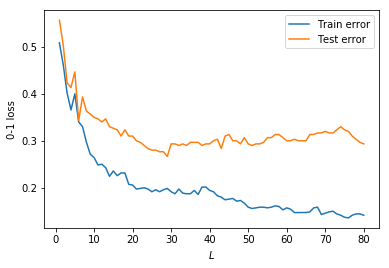

In [13]:
from sklearn.metrics import zero_one_loss

numbers_of_stumps = np.arange(1,81)
train_errors = []
test_errors = []

for number_of_stumps in numbers_of_stumps:
    eclf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=number_of_stumps)
    eclf.fit(X_boost_train, y_boost_train)
    
    train_errors.append(zero_one_loss(y_boost_train, eclf.predict(X_boost_train)))
    test_errors.append(zero_one_loss(y_boost_test, eclf.predict(X_boost_test)))

print(test_errors[np.argmin(test_errors)], np.argmin(test_errors))    

plt.plot(numbers_of_stumps, train_errors, label='Train error')
plt.plot(numbers_of_stumps, test_errors, label='Test error')
plt.legend(loc='best')
plt.xlabel('$L$')
plt.ylabel('0-1 loss')
plt.show()

**Q:** Može li uopće doći do prenaučenosti pri korištenju *boosting*-algoritama?

**A:** Može, no kako je *boosting* algoritam dosta robustan na *overfitting*, on neće biti znatno izražen u promjeni postotka ispitne pogreške.

#### (c)

Kao što je rečeno na početku, *boosting*-algoritmi traže slabe klasifikatore kako bi bili najefikasniji što mogu biti. Međutim, kako se takav ansambl mjeri s jednim **jakim klasifikatorom** (engl. *strong classifier*)? To ćemo isprobati na istom primjeru, ali korištenjem jednog optimalno naučenog stabla odluke.

Ispišite pogrešku ispitivanja optimalnog stabla odluke. Glavni hiperparametar stabala odluka jest njihova maksimalna dubina $d$ (parametar `max_depth`). Iscrtajte krivulje pogrešaka na skupu za učenje i ispitivanje u ovisnosti o dubini stabla $d \in [1,20]$.

0.263333333333 7


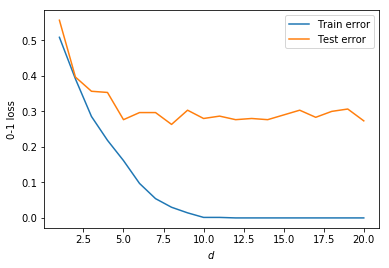

In [14]:
depths = np.arange(1,21)
train_errors = []
test_errors = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_boost_train, y_boost_train)
    
    train_errors.append(zero_one_loss(y_boost_train, clf.predict(X_boost_train)))
    test_errors.append(zero_one_loss(y_boost_test, clf.predict(X_boost_test)))

print(test_errors[np.argmin(test_errors)], np.argmin(test_errors))    

plt.plot(depths, train_errors, label='Train error')
plt.plot(depths, test_errors, label='Test error')
plt.legend(loc='best')
plt.xlabel('$d$')
plt.ylabel('0-1 loss')
plt.show()

**Q:** Isplati li se koristiti ansambl u obliku *boostinga*? Idu li grafikoni tome u prilog?<br>
**Q:** Koja je prednost *boostinga* nad korištenjem jednog jakog klasifikatora?

**A:** Na gore generiranom `(X_boost, y_boost)` skupu podataka *AdaBoost* postiže znatno bolje rezultate naspram stabala odluke, pa ga se u ovom slučaju itekako isplati koristiti.

**A:** Generalna prednost *boostinga* nad pojedinim jakim klasifikatorima je brzina izvođenja. 

### 4. Procjena maksimalne izglednosti i procjena maksimalne aposteriorne vjerojatnosti

#### (a)

Definirajte funkciju izglednosti $\mathcal{L}(\mu|\mathcal{D})$ za skup $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ Bernoullijevih varijabli. Neka od $N$ varijabli njih $m$ ima vrijednost 1 (npr. od $N$ bacanja novčića, $m$ puta smo dobili glavu). Definirajte funkciju izglednosti tako da je parametrizirana s $N$ i $m$, dakle definirajte funkciju $\mathcal{L}(\mu|N,m)$. 

In [15]:
def bernoullis_likelihood(mean, N, m):
    return np.power(mean, m)*np.power((1-mean), (N-m))

#### (b)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za (1) $N=10$ i $m=1,2,5,9$ te za (2) $N=100$ i $m=1,10,50,90$ (dva zasebna grafikona).

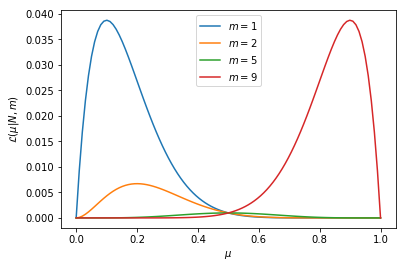

In [16]:
N = 10
ms = [1,2,5,9]
mean = np.linspace(0, 1, num=100)

for m in ms:
    plt.plot(mean, bernoullis_likelihood(mean, N, m), label='$m={}$'.format(m))

plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{L}(\mu|N,m)$')
plt.legend(loc='best')
plt.show()

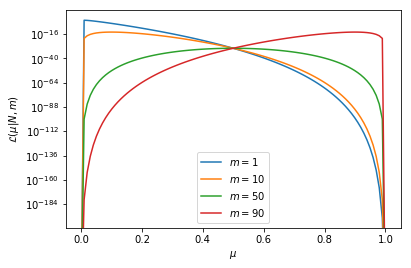

In [17]:
N = 100
ms = [1,10,50,90]
mean = np.linspace(0, 1, num=100)

for m in ms:
    plt.plot(mean, bernoullis_likelihood(mean, N, m), label='$m={}$'.format(m))

plt.yscale('log')
plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{L}(\mu|N,m)$')
plt.legend(loc='best')
plt.show()

**Q:** Koja vrijednost odgovara ML-procjenama i zašto?

**A:** ML-procjenama $\mu$ odgovaraju maksimumi krivulja, jer je MLE $argmax$ izglednosti.

#### (c)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za $N=10$ i $m=\{0,9\}$.

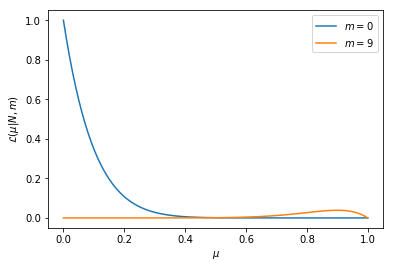

In [18]:
N = 10
ms = [0,9]
mean = np.linspace(0, 1, num=100)

for m in ms:
    plt.plot(mean, bernoullis_likelihood(mean, N, m), label='$m={}$'.format(m))

plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{L}(\mu|N,m)$')
plt.legend(loc='best')
plt.show()

**Q:** Koja je ML-procjena za $\mu$ i što je problem s takvom procjenom u ovome slučaju?

**A:** U gornjem primjeru $\hat{\mu}_{MLE}$ je nula jer je $m=0$, što radi velike probleme kod nekih klasifikatora kao što je to naivni Bayes. Ovo je primjer prenaučenosti MLE procjenitelja kad je $N$ malen.

#### (d)

Prikažite beta-distribuciju $B(\mu|\alpha,\beta)$ za različite kombinacije parametara $\alpha$ i $\beta$, uključivo $\alpha=\beta=1$ te $\alpha=\beta=2$.

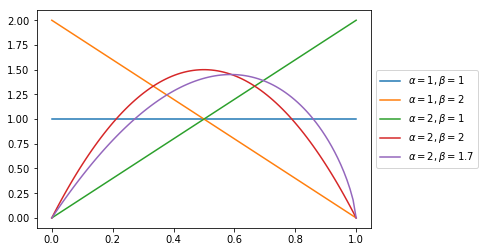

In [19]:
from scipy.stats import beta
from itertools import product

means = np.linspace(0, 1, 100)

for a,b in product(range(1,3), repeat=2):
    plt.plot(means, beta.pdf(means, a, b), label=r'$\alpha={0}, \beta={1}$'.format(a, b))

plt.plot(means, beta.pdf(means, 2, 1.7), label=r'$\alpha=2, \beta=1.7$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Q:** Koje parametere biste odabrali za modeliranje apriornog znanja o parametru $\mu$ za novčić za koji mislite da je "donekle pravedan, ali malo češće pada na glavu"? Koje biste parametre odabrali za novčić za koji držite da je posve pravedan? Zašto uopće koristimo beta-distribuciju, a ne neku drugu?

**A:** Za donekle pravedan novčić koji češće pada na glavu trebalo bi birati $\alpha$ tek nešto veći od $\beta$, s tim da vrijedi $\alpha>1,\beta>1$. 

**A:** Za posve pravedan novčić uzima se $\alpha=2,\beta=2$.

**A:** MAP maksimizira aposteriornu vjerojatnost parametara $p(\theta|\mathcal{D})$, definiranu Bayesovim teoremom. Njena distribucija odgovara distribuciji apriorne vjerojatnosti $p(\theta)$, samo ako je $p(\theta)$ konjugatna apriorna distribucija izglednosti $p(\mathcal(D)|\theta)$. Kako bacanje novčića podliježe Bernoullievoj distribuciji, biramo njenu konjugatnu beta-distribuciju.

#### (e)

Definirajte funkciju za izračun zajedničke vjerojatnosti $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ te prikažite tu funkciju za $N=10$ i $m=9$ i nekolicinu kombinacija parametara $\alpha$ i $\beta$. 

In [20]:
def bernoullis_joint_probability(mean, N, m, a, b):
    return bernoullis_likelihood(mean, N, m) * beta.pdf(mean, a, b)

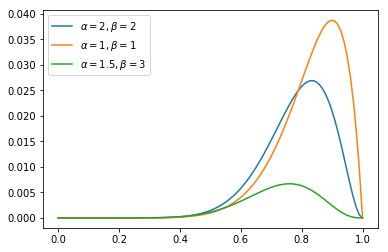

In [21]:
mean = np.linspace(0, 1, num=100)
plt.plot(mean, bernoullis_joint_probability(mean, 10, 9, 2, 2), label=r'$\alpha={0}, \beta={1}$'.format(2, 2))
plt.plot(mean, bernoullis_joint_probability(mean, 10, 9, 1, 1), label=r'$\alpha={0}, \beta={1}$'.format(1, 1))
plt.plot(mean, bernoullis_joint_probability(mean, 10, 9, 1.5, 3), label=r'$\alpha={0}, \beta={1}$'.format(1.5, 3))
plt.legend(loc='best')
plt.show()

**Q**: Koje vrijednosti odgovaraju MAP-procjeni za $\mu$? Usporedite ih sa ML-procjenama.

**A:** MAP-procjene $\mu_{MAP}$ nalaze se u maksimumima funkcija gustoće zajedničke vjerojatnosti. Za $\alpha=\beta=1$ (uniformna, neinformativna apriorna distribucija) MAP degenerira u MLE, ostvarujući maksimum u $\mu_{MAP} \approx 0.9$. Ukoliko se koristi **Laplaceovo zaglađivanje** postavljajući $\alpha=\beta=2$ (apriorna distribucija s najvećom gustoćom u $\mu=0.5$), MAP će biti nešto manje prenaučen u odnosu na MLE, ostvarujući maksimum u $\mu_{MAP} \approx 0.8$.

#### (f)

Za $N=10$ i $m=1$, na jednome grafikonu prikažite sve tri distribucije: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ i $\mathcal{L}(\mu|\mathcal{D})$.

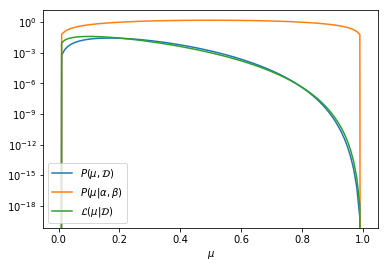

In [22]:
mean = np.linspace(0, 1, num=100)
N, m = 10, 1
a, b = 2, 2

plt.plot(mean, bernoullis_joint_probability(mean, N, m, a, b), label=r'$P(\mu, \mathcal{D})$')
plt.plot(mean, beta.pdf(mean, a, b), label=r'$P(\mu|\alpha,\beta)$')
plt.plot(mean, bernoullis_likelihood(mean, N, m), label=r'$\mathcal{L}(\mu|\mathcal{D})$')

plt.yscale('log')
plt.xlabel('$\mu$')
plt.legend(loc='best')
plt.show()

#### (g)

Pročitajte [ove](http://scikit-learn.org/stable/datasets/) upute o učitavanju oglednih skupova podataka u SciPy. Učitajte skup podataka *Iris*. Taj skup sadrži $n=4$ značajke i $K=3$ klase. Odaberite jednu klasu i odaberite sve primjere iz te klase, dok ostale primjere zanemarite (**u nastavku radite isključivo s primjerima iz te jedne klase**). Vizualizirajte podatke tako da načinite 2D-prikaze za svaki par značajki (šest grafikona; za prikaz je najjednostavnije koristiti funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)).

**NB:** Mogla bi Vam dobro dući funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

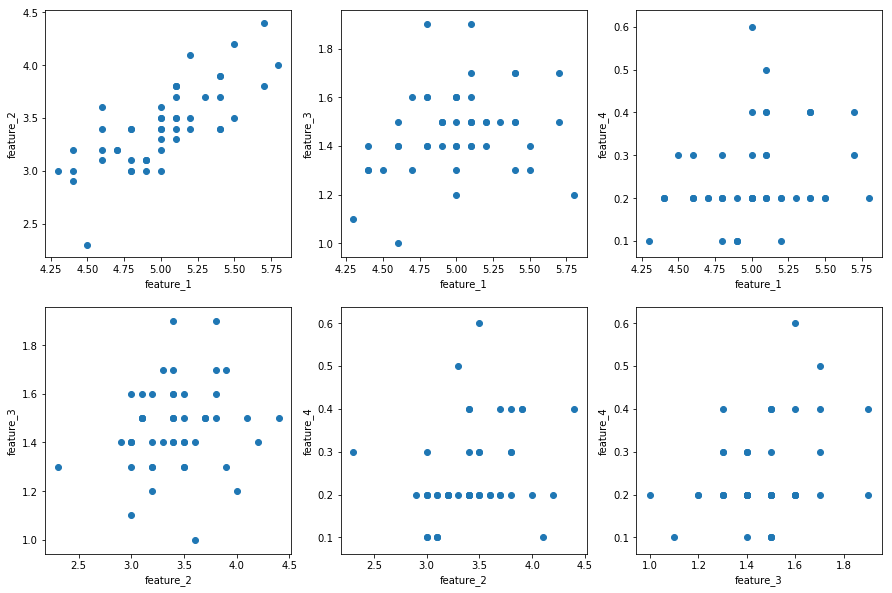

In [23]:
from sklearn.datasets import load_iris
import itertools as it

iris = load_iris()
X = iris.data[iris.target == 0]

plt.figure(figsize=(15,10))
n_sub = 1

for i,j in it.combinations(range(4), 2):
    plt.subplot(2, 3, n_sub)
    plt.scatter(X[:,i], X[:,j])
    plt.xlabel('feature_{}'.format(i+1))
    plt.ylabel('feature_{}'.format(j+1))
    n_sub += 1

plt.show()

#### (h)

Implementirajte funkciju log-izglednosti za parametre $\mu$ i $\sigma^2$ normalne distribucije.

In [24]:
def normal_log_likelihood(X, mean, variance):
    return -0.5*X.shape[0]*np.log(2*math.pi) - X.shape[0]*np.log(math.sqrt(variance)) - np.sum(np.power((X-mean),2))/(2*variance)

#### (i)
Izračunajte ML-procjene za $(\mu, \sigma^2)$ za svaku od $n=4$ značajki iz skupa *Iris*. Ispišite log-izglednosti tih ML-procjena. 

In [30]:
for n_feature in range(4):
    mean = np.mean(X[:,n_feature])
    variance = np.var(X[:,n_feature])
    #print(np.median(X[:,n_feature]), mean, variance, 0.5*(np.amax(X[:,n_feature]) - np.amin(X[:,n_feature])))
    print('feature_{0}: {1}'.format(n_feature+1, normal_log_likelihood(X[:,n_feature], mean, variance)))

feature_1: -18.305163312803863
feature_2: -22.197265513335253
feature_3: 17.133809129965208
feature_4: 41.2066603289276


**Q:** Možete li, na temelju dobivenih log-izglednosti, zaključiti koja se značajka najbolje pokorava normalnoj distribuciji? 

**A:** Sama izglednost ne daje mjeru pokoravanja značajke određenoj distribuciji, visoka izglednost neke značajke prije ukazuje na vrlo malu varijancu, zbog čega gustoće vjerojatnosti primjera postižu visoke iznose, pa tako i njihov produkt tj. izglednost. Za dobru mjeru pokoravanja distribuciji, valjalo bi izvršiti LR test (*Likelihood-ratio*) za normalnu distribuciju, ili neki drugi test normalnosti (*Normality test*).

#### (j)

Proučite funkciju [`pearsonr`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) za izračun Pearsonovog koeficijenta korelacije. Izračunajte koeficijente korelacije između svih četiri značajki u skupu *Iris*. 

In [34]:
from scipy.stats import pearsonr

for i,j in it.combinations(range(4), 2):
    print('PCC (feature_{0}, feature_{1}): {2}'.format(i+1, j+1, pearsonr(X[:,i], X[:,j])[0]))

PCC (feature_1, feature_2): 0.7467803732639268
PCC (feature_1, feature_3): 0.26387409291868696
PCC (feature_1, feature_4): 0.27909157499959675
PCC (feature_2, feature_3): 0.17669462869680694
PCC (feature_2, feature_4): 0.2799728885169045
PCC (feature_3, feature_4): 0.3063082111580356


#### (k)

Proučite funkciju [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) te izračunajte ML-procjenu za kovarijacijsku matricu za skup *Iris*. Usporedite pristranu i nepristranu procjenu. Pokažite da se razlika (srednja apsolutna i kvadratna) smanjuje s brojem primjera (npr. isprobajte za $N/4$ i $N/2$ i $N$ primjera).

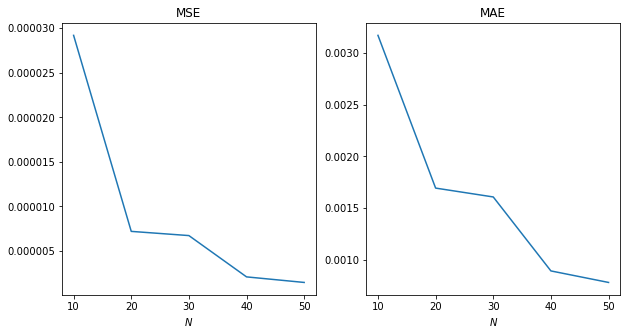

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

squared_errors = []
absolute_errors = []
ns_samples = range(X.shape[0], 2, -10)

for n_samples in ns_samples:
    X_subsample = X[np.random.choice(X.shape[0], size=n_samples, replace=False), :]
    mle_cov_biased = np.cov(X_subsample, rowvar=False, bias=True)
    mle_cov_unbiased = np.cov(X_subsample, rowvar=False, bias=False)

    squared_errors.append(mean_squared_error(mle_cov_biased, mle_cov_unbiased))
    absolute_errors.append(mean_absolute_error(mle_cov_biased, mle_cov_unbiased))
    
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('MSE')
plt.xlabel('$N$')
plt.plot(ns_samples, squared_errors)

plt.subplot(122)
plt.title('MAE')
plt.plot(ns_samples, absolute_errors)
plt.xlabel('$N$')

plt.show()